In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.signal import convolve2d

In [2]:
def imshow(R, G, B):
    img = np.zeros((r, r, 3), dtype=np.float64)
    
    # Normalize
    for i, c in enumerate((R, G, B)):
        c += np.abs(c.min())
        c /= c.max()
        img[:,:,i] = c

    fig, ax = plt.subplots()
    ax.imshow(img)
    fig.set_size_inches(8, 8)

In [3]:
def wavelength_to_rgb(w, gamma=0.8):
    ''' adapted from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm.
    '''
    rgb = np.zeros((w.shape[0], w.shape[1], 3), dtype=np.float64)
    
    for i, j in product(range(w.shape[0]), range(w.shape[1])):
        wavelength = w[i, j]
        
        if wavelength < 380 or wavelength > 780:
            raise ValueError('Wavelength must be between 380 nm and 780 nm.')
            
        if wavelength >= 380 and wavelength <= 440:
            attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
            rgb[i, j, 0] = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
            rgb[i, j, 1] = 0.0
            rgb[i, j, 2] = (1.0 * attenuation) ** gamma
        elif wavelength >= 440 and wavelength <= 490:
            rgb[i, j, 0] = 0.0
            rgb[i, j, 1] = ((wavelength - 440) / (490 - 440)) ** gamma
            rgb[i, j, 2] = 1.0
        elif wavelength >= 490 and wavelength <= 510:
            rgb[i, j, 0] = 0.0
            rgb[i, j, 1] = 1.0
            rgb[i, j, 2] = (-(wavelength - 510) / (510 - 490)) ** gamma
        elif wavelength >= 510 and wavelength <= 580:
            rgb[i, j, 0] = ((wavelength - 510) / (580 - 510)) ** gamma
            rgb[i, j, 1] = 1.0
            rgb[i, j, 2] = 0.0
        elif wavelength >= 580 and wavelength <= 645:
            rgb[i, j, 0] = 1.0
            rgb[i, j, 1] = (-(wavelength - 645) / (645 - 580)) ** gamma
            rgb[i, j, 2] = 0.0
        elif wavelength >= 645 and wavelength <= 780:
            attenuation = 0.3 + 0.7 * (750 - wavelength) / (780 - 645)
            rgb[i, j, 0] = (1.0 * attenuation) ** gamma
            rgb[i, j, 1] = 0.0
            rgb[i, j, 2] = 0.0
        else:
            rgb[i, j, 0] = 0.0
            rgb[i, j, 1] = 0.0
            rgb[i, j, 2] = 0.0
    return rgb

# Photoreceptors

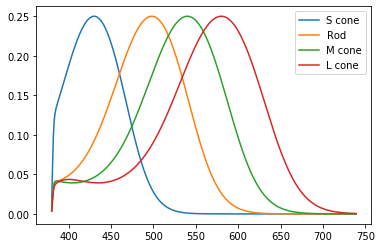

In [4]:
def sensitivity(l, lm):
    receptor_od = 0.3
    lens_od = 10**(-0.5 * (l - 380))
    macular_pigment_od = 0.3
    a = np.array([-5.2734, -87.403, 1228.4, -3346.3, -5070.3, 30881, -31607])
    b = np.zeros((7, *l.shape)) if type(l) is np.ndarray else np.zeros(7)
    b[0] = a[0]
    
    k = lm / (0.561 * l)
    
    for i in range(1, 7):
        b[i] = a[i] * np.log10(k)**i
    sens = 10**(- lens_od - macular_pigment_od) * (1 - 10**(-receptor_od * 10**(b.sum(axis=0))))
    np.nan_to_num(sens, copy=False)
    return sens
    

# Draw tuning curves
fig, ax = plt.subplots()

l = np.arange(380, 740)
s = np.zeros(l.shape[0])

for lm, c in zip((430, 498, 540, 580), ('S cone', 'Rod', 'M cone', 'L cone')):
    s = sensitivity(l, lm)
    ax.plot(l, s, label=c)
ax.legend()

In [5]:
def quantal_catch(spectral_im, sensitivity):
    catch = spectral_im * sensitivity[None, ...]
    return catch.sum(axis=2)

# Horizontal Cell

In [6]:
# Retina size
r = 300

# Surrounding size
sradius = 5

# scale
k = 0.7

# sigma's
sig1, sig2 = 0.5, 2

# Horizontal Cell
axis_values = np.arange(-sradius, sradius + 1)
xvalues, yvalues = np.meshgrid(axis_values, axis_values, indexing='xy')

gc = 1 / (2 * np.pi * sig1**2) * np.exp(-(xvalues**2 + yvalues**2) / (2 * sig1**2))
gs = 1 / (2 * np.pi * sig2**2) * np.exp(-(xvalues**2 + yvalues**2) / (2 * sig2**2))

H_ON = gc - k * gs

H_OFF = -H_ON

H_ON.max(), H_ON.min()

(0.6087676573264997, -0.016679599568446307)

# Lateral Inhibition as Image Filtering with DoG

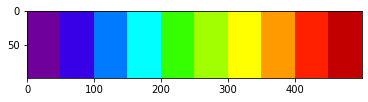

In [7]:
w = np.zeros((100, 500))
for i in range(10):
    w[:, i*50:(i+1)*50] = 400 + i * 30
plt.imshow(wavelength_to_rgb(w))

Text(0.5, 0.98, 'Responses to the Figure Above')

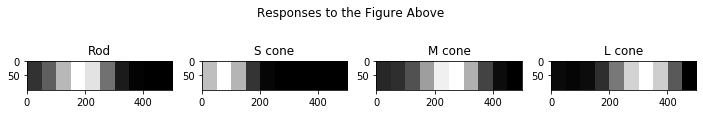

In [8]:
photoreceptors = np.zeros((4, *w.shape))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(12, 2)
for p, lm, c in zip((0, 1, 2, 3), (498, 430, 540, 580), ('Rod', 'S cone', 'M cone', 'L cone')):
    photoreceptors[p] = sensitivity(w, lm)
    minp = photoreceptors[p].min()
    maxp = photoreceptors[p].max()
    photoreceptors[p] = (photoreceptors[p] - minp) / (maxp - minp)
    ax[p].imshow(photoreceptors[p], 'gray', vmin=0, vmax=1)
    ax[p].set_title(c)
fig.suptitle('Responses to the Figure Above')

Text(0.5, 0.98, 'Filtered Responses to the Figure Above')

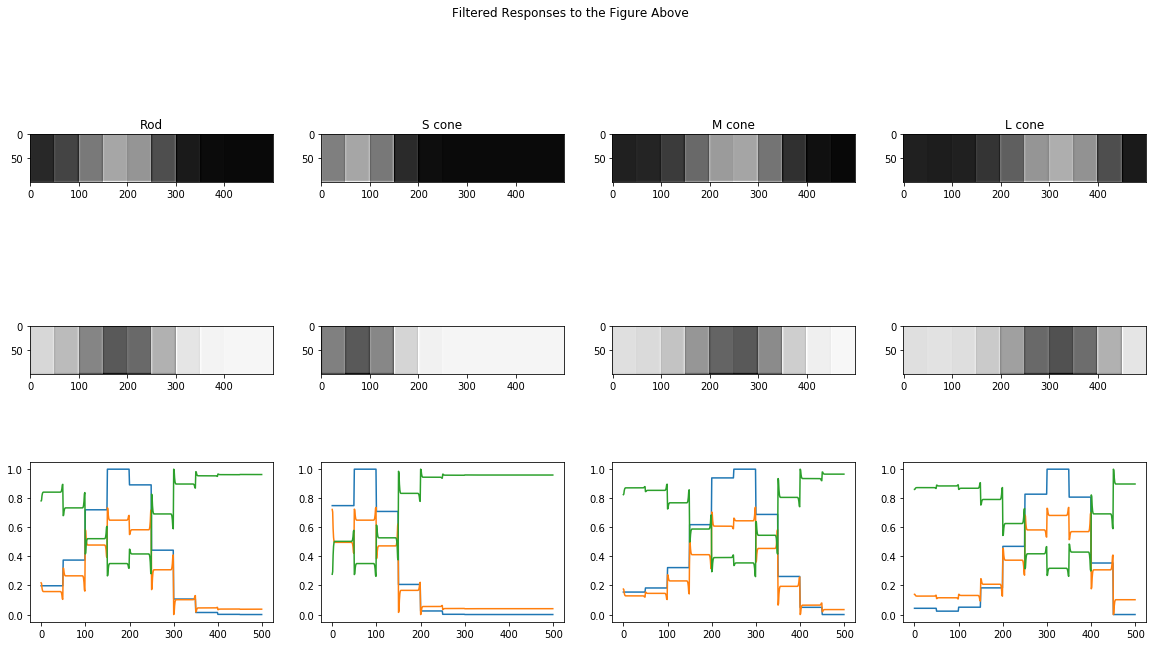

In [9]:
m_photoreceptors = np.zeros(photoreceptors.shape)
fig, ax = plt.subplots(3, 4)
fig.set_size_inches(20, 10)
for p, c in zip((0, 1, 2, 3), ('Rod', 'S cone', 'M cone', 'L cone')):
    m_photoreceptors[p] = convolve2d(photoreceptors[p], H_ON, 'same')
    minp = m_photoreceptors[p].min()
    maxp = m_photoreceptors[p].max()
    m_photoreceptors[p] = (m_photoreceptors[p] - minp) / (maxp - minp)
    
    ax[0, p].imshow(m_photoreceptors[p], 'gray', vmin=0, vmax=1)
    ax[0, p].set_title(c)
    
    ax[2, p].plot(photoreceptors[p, 10]) # Without Horizontal Cells
    ax[2, p].plot(m_photoreceptors[p, 10]) # ON--With Horizontal Cells
    
    m_photoreceptors[p] = convolve2d(photoreceptors[p], H_OFF, 'same')
    minp = m_photoreceptors[p].min()
    maxp = m_photoreceptors[p].max()
    m_photoreceptors[p] = (m_photoreceptors[p] - minp) / (maxp - minp)
    
    ax[1, p].imshow(m_photoreceptors[p], 'gray', vmin=0, vmax=1)
    
    ax[2, p].plot(m_photoreceptors[p, 10]) # OFF--With Horizontal Cells
    
fig.suptitle('Filtered Responses to the Figure Above')

# Retina without Photoreceptor Overlapping

In [10]:
distribution = np.random.randint(1, 4, (100, 500))

/home/ziyi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/ziyi/.local/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Text(0.5, 0.98, 'Responses to the Figure Above')

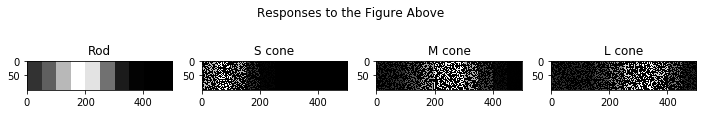

In [11]:
photoreceptors = np.zeros((4, *w.shape))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(12, 2)
for p, lm, c in zip((0, 1, 2, 3), (498, 430, 540, 580), ('Rod', 'S cone', 'M cone', 'L cone')):
    if p > 0:
        photoreceptors[p] = sensitivity(w * (distribution == p), lm)
    else:
        photoreceptors[p] = sensitivity(w, lm)
    minp = photoreceptors[p].min()
    maxp = photoreceptors[p].max()
    photoreceptors[p] = (photoreceptors[p] - minp) / (maxp - minp)
    ax[p].imshow(photoreceptors[p], 'gray', vmin=0, vmax=1)
    ax[p].set_title(c)
fig.suptitle('Responses to the Figure Above')

Text(0.5, 0.98, 'Filtered Responses to the Figure Above')

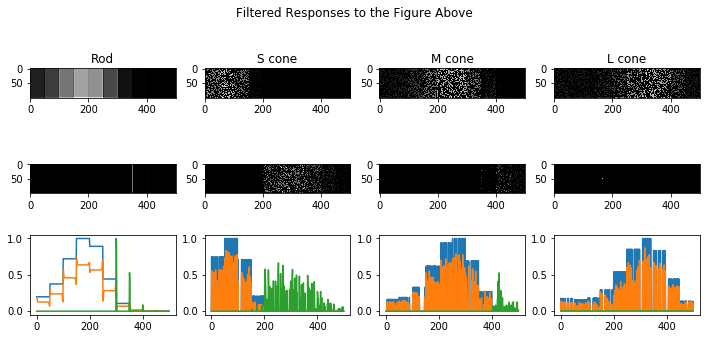

In [12]:
m_photoreceptors = np.zeros((2, *photoreceptors.shape))
fig, ax = plt.subplots(3, 4)
fig.set_size_inches(12, 5)

for i, h in enumerate((H_ON, H_OFF)):
    m_photoreceptors[i, 0] = convolve2d(photoreceptors[0], h, 'same')
    m_photoreceptors[i, 1] = convolve2d(photoreceptors[1:].sum(axis=0), h, 'same') * (distribution == 1)
    m_photoreceptors[i, 2] = convolve2d(photoreceptors[2:].sum(axis=0), h, 'same') * (distribution == 2)
    m_photoreceptors[i, 3] = convolve2d(photoreceptors[2:].sum(axis=0), h, 'same') * (distribution == 3)
    

m_photoreceptors[m_photoreceptors < 0] = 0

for p, c in zip((0, 1, 2, 3), ('Rod', 'S cone', 'M cone', 'L cone')):
    minp = m_photoreceptors[0, p].min()
    maxp = m_photoreceptors[0, p].max()
    m_photoreceptors[0, p] = (m_photoreceptors[0, p] - minp) / (maxp - minp)
    ax[0, p].imshow(m_photoreceptors[0, p], 'gray', vmin=0, vmax=1)
    ax[0, p].set_title(c)
    
    ax[2, p].plot(photoreceptors[p, 10]) #Without Horizontal Cells
    ax[2, p].plot(m_photoreceptors[0, p, 10]) # ON--With Horizontal Cells
    
    minp = m_photoreceptors[1, p].min()
    maxp = m_photoreceptors[1, p].max()
    m_photoreceptors[1, p] = (m_photoreceptors[1, p] - minp) / (maxp - minp)
    
    ax[1, p].imshow(m_photoreceptors[1, p], 'gray', vmin=0, vmax=1)
    
    ax[2, p].plot(m_photoreceptors[1, p, 10]) # OFF--With Horizontal Cells
fig.suptitle('Filtered Responses to the Figure Above')

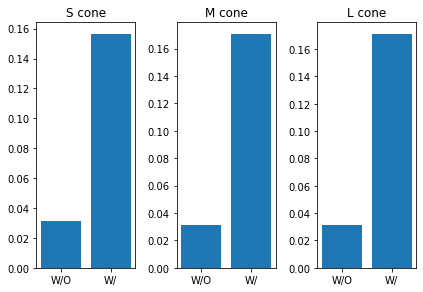

In [13]:
size = photoreceptors.size / 3
rms = np.zeros(2)

fig, ax = plt.subplots(1, 3)
fig.tight_layout()

for p, c in zip((1, 2, 3), ('S cone', 'M cone', 'L cone')):
    mean = photoreceptors[0, p].mean()
    rms[0] = np.sqrt(np.sum((photoreceptors[0, p] - mean)**2) / size)
    
    mean = m_photoreceptors[0, p].mean()
    rms[1] = np.sqrt(np.sum((m_photoreceptors[0, p] - mean)**2) / size)
    
    ax[p-1].bar([0, 1], rms, align='center')
    ax[p-1].set_xticks([0, 1])
    ax[p-1].set_xticklabels(['W/O', 'W/'])
    ax[p-1].set_title(c)

# Fruit-Leaf Scheme

Text(0.5, 1.0, 'Reference Pattern')

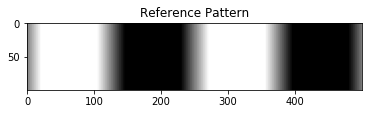

In [14]:
cycle = 2
gradient_strength = 1
wave = 1 / gradient_strength * np.sin(2 * np.pi * cycle / 500 * np.arange(500)) + 0.5
wave[wave > 1] = 1
wave[wave < 0] = 0
reference_pattern = np.tile(wave, (100, 1))

plt.imshow(reference_pattern, 'gray', vmin=0, vmax=1)
plt.title('Reference Pattern')

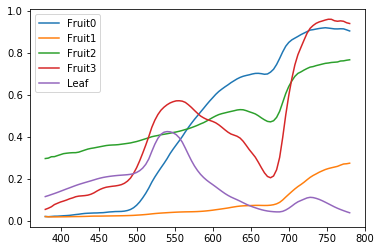

In [15]:
fruit_data = np.load('fruit.npy')
leaf_data = np.load('leaf.npy')
illum_data = np.load('illum.npy')

wavelengths = np.arange(380, 784, 4)
for i in range(4):
    plt.plot(wavelengths, fruit_data[i], label='Fruit{}'.format(i))
plt.plot(wavelengths, leaf_data, label='Leaf')
plt.legend()

In [16]:
tests = np.zeros((4, 4, *reference_pattern.shape, 101))
tests[:] = reference_pattern[..., None]

discretized_S = sensitivity(wavelengths, 430)
discretized_R = sensitivity(wavelengths, 498)
discretized_M = sensitivity(wavelengths, 540)
discretized_L = sensitivity(wavelengths, 580)

tests_RGB = np.zeros((4, 4, *reference_pattern.shape, 3))
tests_RGB[:, :] = reference_pattern[..., None]

sRGB = np.array([[3.2404542, -1.5371385, -0.4985314],
                 [-0.9692660, 1.8760108, 0.0415560],
                 [0.0556434, -0.2040259,  1.0572252]])

for i, j in product(range(4), range(4)):
    fruit = fruit_data[j] * illum_data[i]
    leaf = leaf_data * illum_data[i]
    tests[i, j, :] = tests[i, j, :] * fruit + (1 - tests[i, j, :]) * leaf
    
    fs = (fruit * discretized_S).sum()
    fm = (fruit * discretized_M).sum()
    fl = (fruit * discretized_L).sum()
    ls = (leaf * discretized_S).sum()
    lm = (leaf * discretized_M).sum()
    ll = (leaf * discretized_L).sum()
    
    for p, q in product(range(100), range(500)):
        tests_RGB[i, j, p, q, 0] = reference_pattern[p, q] * fl + (1 - reference_pattern[p, q]) * ll
        tests_RGB[i, j, p, q, 1] = reference_pattern[p, q] * fm + (1 - reference_pattern[p, q]) * lm
        tests_RGB[i, j, p, q, 2] = reference_pattern[p, q] * fs + (1 - reference_pattern[p, q]) * ls
        tests_RGB[i, j, p, q] = sRGB @ tests_RGB[i, j, p, q]
tests_RGB[tests_RGB > 1] = 1
tests_RGB[tests_RGB < 0] = 0

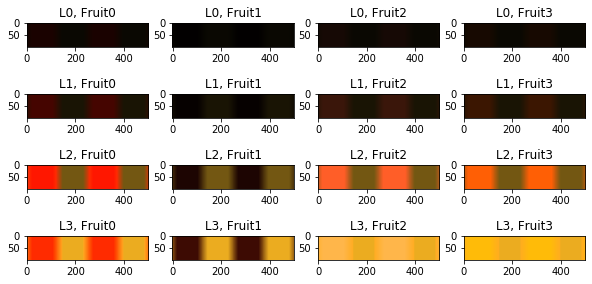

In [17]:
fig, ax = plt.subplots(4, 4)
fig.set_size_inches(10, 5)
for i, j in product(range(4), range(4)):
    ax[i, j].imshow(tests_RGB[i, j])
    ax[i, j].set_title('L{}, Fruit{}'.format(i, j))

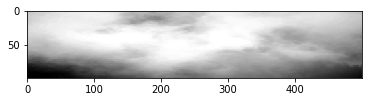

In [18]:
fog = np.load('fog.npy')
from cv2 import resize
fog = resize(fog, (500, 100))
plt.imshow(fog, 'gray')

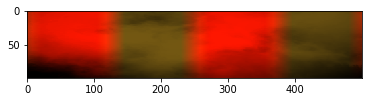

In [19]:
# Pick L2F0 for test1
test1 = tests[2, 0] * fog[..., None]
test1_RGB = tests_RGB[2, 0] * fog[..., None]
plt.imshow(test1_RGB)

In [20]:
catch = np.zeros((2, 4, 100, 500))
for i, sens in enumerate((discretized_R, discretized_S, discretized_M, discretized_L)):
    if i == 0:
        catch[0, i] = quantal_catch(test1, sens)
        
        minp = catch[0, i].min()
        maxp = catch[0, i].max()
        catch[0, i] = (catch[0, i] - minp) / (maxp - minp)
        catch[1, i] = 1 - catch[0, i]
    else:
        catch[0, i] = quantal_catch(test1 * (distribution == i)[..., None], sens)
        
        minp = catch[0, i, distribution == i].min()
        maxp = catch[0, i, distribution == i].max()
        catch[0, i, distribution == i] = (catch[0, i, distribution == i] - minp) / (maxp - minp)
        catch[1, i] = 1 - catch[0, i]
        catch[1, i, distribution != i] = 0


Text(0.5, 0.98, 'Non-filtered Responses to the Figure Above')

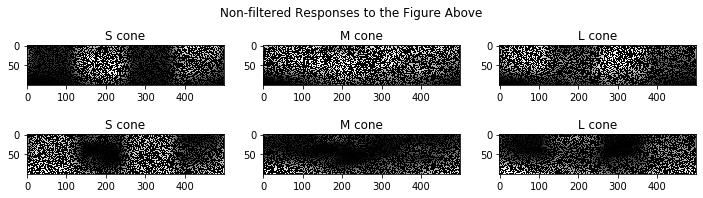

In [21]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(12, 3)
for p, c in zip((1, 2, 3), ('S cone', 'M cone', 'L cone')):
    for i in range(2):

        np.nan_to_num(catch[i, p], copy=False)
        ax[i, p-1].imshow(catch[i, p], 'gray')#, vmin=0, vmax=1)
        ax[i, p-1].set_title(c)
fig.suptitle('Non-filtered Responses to the Figure Above')

In [22]:
m_catch = np.zeros(catch.shape)
for i in range(2):
    m_catch[i, 0] = convolve2d(catch[i, 0], H_ON, 'same')
    m_catch[i, 1] = convolve2d(catch[i, 1:].sum(axis=0), H_ON, 'same') * (distribution == 1)
    m_catch[i, 2] = convolve2d(catch[i, 2:].sum(axis=0), H_ON, 'same') * (distribution == 2)
    m_catch[i, 3] = convolve2d(catch[i, 2:].sum(axis=0), H_ON, 'same') * (distribution == 3)
m_catch[m_catch < 0] = 0

Text(0.5, 0.98, 'Filtered Responses to the Figure Above')

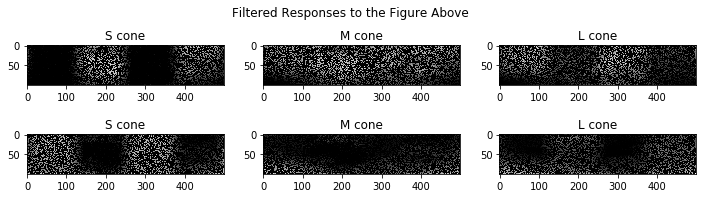

In [23]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(12, 3)
for p, c in zip((1, 2, 3), ('S cone', 'M cone', 'L cone')):
    for i in range(2):
        minp = m_catch[i, p, distribution == p].min()
        maxp = m_catch[i, p, distribution == p].max()
        m_catch[i, p, distribution == p] = (m_catch[i, p, distribution == p] - minp) / (maxp - minp)
        np.nan_to_num(m_catch[i, p], copy=False)
        ax[i, p-1].imshow(m_catch[i, p], 'gray')#, vmin=0, vmax=1)
        ax[i, p-1].set_title(c)
fig.suptitle('Filtered Responses to the Figure Above')

# Hering's Theory of Color Opponency

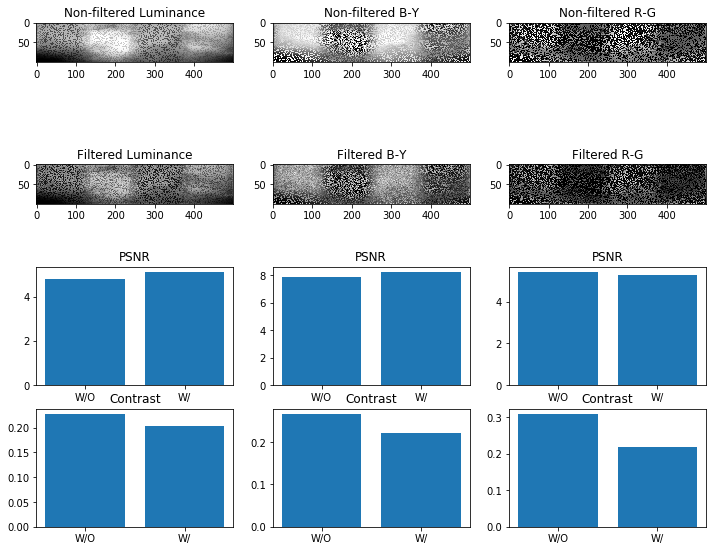

In [24]:
lum = [catch[0, :].sum(axis=0), m_catch[0, :].sum(axis=0)]
b_y = [catch[0, 2:].sum(axis=0) + catch[1, 1], m_catch[0, 2:].sum(axis=0) + m_catch[1, 1]]
r_g = [catch[0, 3] + catch[1, 2], m_catch[0, 3] + m_catch[1, 2]]

fig, ax = plt.subplots(4, 3)
fig.set_size_inches(12, 10)
psnr = np.zeros(2)
contrast = psnr.copy()
size = reference_pattern.size
for i, (c, name) in enumerate(zip((lum, b_y, r_g), ('Luminance', 'B-Y', 'R-G'))):
    
    for j, prefix in enumerate(('Non-filtered ', 'Filtered ')):
        minp = c[j].min()
        maxp = c[j].max()
        c[j] = (c[j] - minp) / (maxp - minp)
        ax[j, i].imshow(c[j], 'gray')
        ax[j, i].set_title(prefix + name)
        
        rms = np.sqrt(np.sum((c[j] - reference_pattern)**2) / size)
        psnr[j] = - 20 * np.log10(rms)
        
        mean = c[j].mean()
        contrast[j] = np.sqrt(np.sum((c[j] - mean)**2) / size)
        
    ax[2, i].bar([0, 1], psnr)
    ax[2, i].set_xticks([0, 1])
    ax[2, i].set_xticklabels(['W/O', 'W/'])
    ax[2, i].set_title('PSNR')
    ax[3, i].bar([0, 1], contrast)
    ax[3, i].set_xticks([0, 1])
    ax[3, i].set_xticklabels(['W/O', 'W/'])
    ax[3, i].set_title('Contrast')